# R: Decision Tree Applications

# Overview 
## Background 
A decision tree is a flowchart-like structure which models the decisions and their possible consequences, including chance of event outcomes, resource costs, and utility.

In a decision tree, each internal node is split by a single feature. The tree then develops branches leading to lower level of subgroups that increases the homogeneity of the elements within that group. The split on a feature is not influenced by other features. Such division process is repeated until all leaf nodes are reached. The paths from root to leaf represent classification rules.

![Evolution of Tree-based Algorithms (source: https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance)](../_static/trees/tree_based_algorithms.jpeg)

## Libraries
A list of packages used in the recipes below.

In [1]:
library(rmdformats)     # theme for the HTML doc
library(bookdown)       # bibliography formatting
library(scales)         # data formatting  
library(dplyr)          # tidyverse: data manipulation
library(tidyr)          # tidyverse: tidy messy data
library(MASS)           # statistics
library(ggplot2)        # tidyverse: graphs
library(ggthemes)       # tidyverse: additional themes for ggplot, optional
library(pROC)           # visualising ROC curves
library(caret)          # for Classification And REgression Training
library(rpart)          # Decision tree algorithm
library(rpart.plot)     # Plot for decision tree
library(randomForest)   # random forest algorithm
library(xgboost)        # XGBoost algorithm


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: lattice

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




# Prepare Data
Let's use the same dataset as in the "Regression" article. That data looked at disability income insurance experience.

In [2]:
rm(list = ls())
load(file = "../_static/trees/data.RData",)

Split data into training and testing sets:

In [3]:
# Determine the number of rows for training
nrow(df)
# Create a random sample of row IDs
sample_rows <- sample(nrow(df),0.75*nrow(df))
# Create the training dataset
df_train <- df[sample_rows,]
# Create the test dataset
df_test <- df[-sample_rows,]


samp_cv <- sample(1:nrow(df_test),100000)
df_cv <- df_test[samp_cv,]
df_test2 <- df_test[-samp_cv,]

# One hot encoding
train_label <- df_train$inc_count_tot
cv_label <- df_cv$inc_count_tot
test_label <- df_test2$inc_count_tot

[1] 600000

# Decision tree
## Introduction to decision trees
Decision trees uses a technique called "divide-and-conquer", which divides the dataset into partitions with similar values for the outcome of interest. To divide-and-conquer, the algorithm looks for an initial split that creates the two most homogeneous groups, and repeat this process till all the leaf nodes are reached.

Leaf nodes represent the final outcome of all the determinations, which are the lowest levels of decision trees. It describes the classes (or types) of the output variable in classification problems, or its predicted values in regression problems.

An obvious question is how does the algorithm decide where to split the dataset? For example, if one of the factors is "age", how does the model know to split it at age 30, 40, or 50, in order to achieve the best "two most homogeneous" groups? For classification trees, the common solutions are Gini impurity and Entropy.

### Gini impurity
Gini impurity is a common approach to calculate the goodness of split in a numeric way, which helps decide where to split the dataset.

Gini impurity is a measurement of the likelihood of an incorrect classification of the sample randomly selected. The lower the Gini impurity, the less likely a mis-classification will occur, and the subgroup is "purer". It reaches 0 when the dataset contains only one class ("purest" scenario).

Gini impurity is denoted as
$G(x) = \sum_{i=1}^n P(x_i)(1 - P(x_i)) = 1 - \sum^n_{i=1} P(x_i)^2$
where $p_k$ is the probability of a correct classification within the subgroup. 

![Gini Impurity calculation](../_static/trees/gini_impurity.png)

In the example of whether having chest pain in relation to heart disease, the Gini impurity can be calculated as follows:

$P_1 = P\text{(Has heart disease with chest pain)} = \frac{105}{105 + 39} = 0.7862$
$P_2 = P\text{(No heart disease with chest pain)} = \frac{39}{105 + 39} = 0.2708$
$P_3 = P\text{(Has heart disease without chest pain)} = \frac{34}{34 + 125} = 0.2138$
$P_4 = P\text{(No heart disease without chest pain)} = \frac{125}{34 + 125} = 0.7292$
The Gini impurity for the left group is
$ G(Left) = 1 - P_1^2 - P_2^2 = 0.3950$

The Gini impurity for the right group is
$ G(Right) = 1 - P_3^2 - P_4^2 = 0.3362$

The overall Gini impurity for the division is a weighted average of the Gini impurity of the two groups, based on the number of observations within each group.

$ G = \frac{144}{144 + 159} \times G(Left) + \frac{159}{144 + 159} \times G(Right) = 0.364$

Similarly, the Gini impurity for whether having good blood circulation as condition is 0.360. In this case, it is a slightly better indicator than whether having chest pain. 

### Entropy
Entropy is a concept in information theory introduced by Claude Shannon in his 1948 paper "A Methematical Theory of Communication". It is denoted as follows
$ H(x) =  - \sum_{i=1}^n P(x_i)ln(P(x_i))$

Entropy varies between $[0, 1]$ while Gini impurity varies $[0,0.5]$. The two have very similar distribution especially when Entropy is compared to twice of the Gini impurity. The conclusion from the two are mostly the same (only disagree in 2% of time). In many cases Gini impurity is favoured, as Entropy requires more computational power for using log function.

### Information gain
After we get (information) entropy, we can calculate the information gain for a particular feature when learning.

Suppose one of the features is gender. If we choose to split dataset by gender, then can be sub-divided into 2 groups, $D_{male}$ and $D_{female}$. So the entropy after splitting by gender, is the weighted average of the entropy of the two sets

$ \frac{D_{male}}{D}H(D_{male}) + \frac{D_{female}}{D}H(D_{female}) $

When compared to the information entropy prior to the split, the reduction is the information gain, denoted as

$ Gain(D, feature)=H(D)-\sum^{N}_{i=1}\frac{D_i}{D}H(D_i) $

The information gain is then used to determine whether it's better or worse off to perform a further split, and which feature yields higher gain.

### Information gain ratio
One potential issue with information gain is that it prefers features with more categories. For instance, if we choose to split by personal ID which is a unique value, the entire dataset will be divided into $N$ groups where $N$ is also the number of data points. In this case, the entropy of each group will be zero given there is only 1 observation and the accuracy of classification reaches 100%, which then makes the second term (average entropy after split) of above formula zero. Apparently such division is not meaningful even though it maximises the information gain.

To improve this, the information gain ratio was developed. It is written as

$ Gain\_ratio(D, feature)=\frac{Gain(D, feature)}{IV(feature)}$
where $IV(feature)$ can be further denoted as

$ IV(feature)=-\sum_{i=1}^N \frac{D_i}{D}ln(\frac{D_i}{D})$

This looks similar to information entropy, which essentially evaluates the purity of the feature. If the feature only has few categories, it's "purer" and the $IV$ values is smaller, vice versa. Therefore it adds a penalty on selecting features with many categories.

However, information gain ratio is still not perfect, as it tends to choose features with less categories. Therefore, C4.5, a typical algorithm that uses information gain ratio, also uses information gain. It first calculates the average of information gain of all possible splits, and then choose the split with information gain above this average but also has the maximum information gain ratio, as the best split. 

## Classification tree example
Let's model whether a policy has any claim incident, by looking at indicator of sickness ($\text{inc_count_sick}$) and accident ($\text{inc_count_acc}$). Apparently the dependent variable ($\text{inc_count_tot}$) is fully determined by the two indicators. "Class" method is used here to train the classification tree.

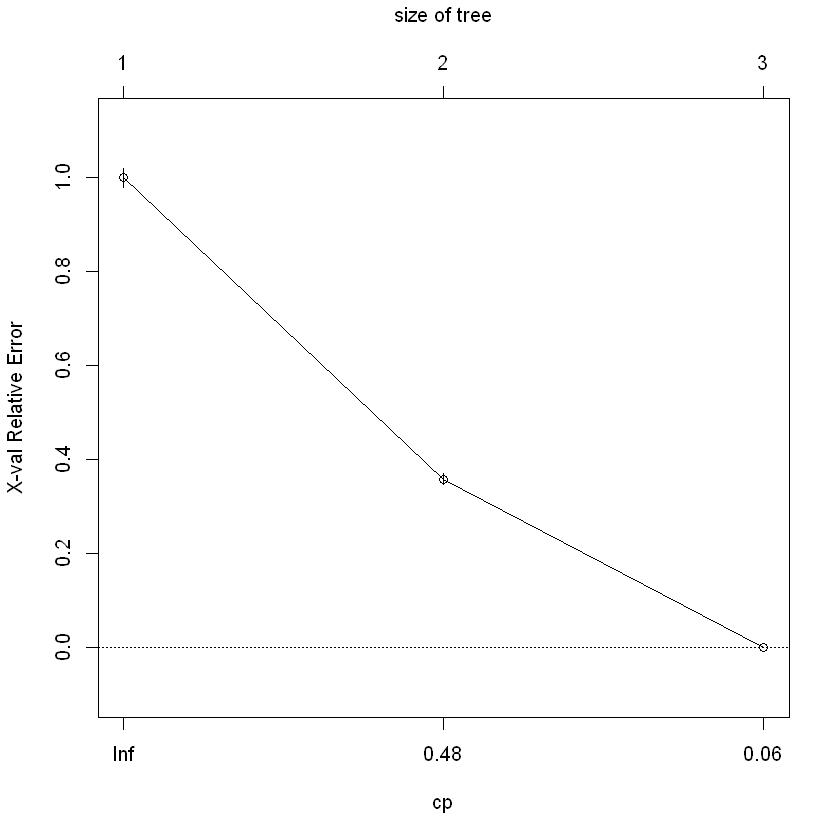

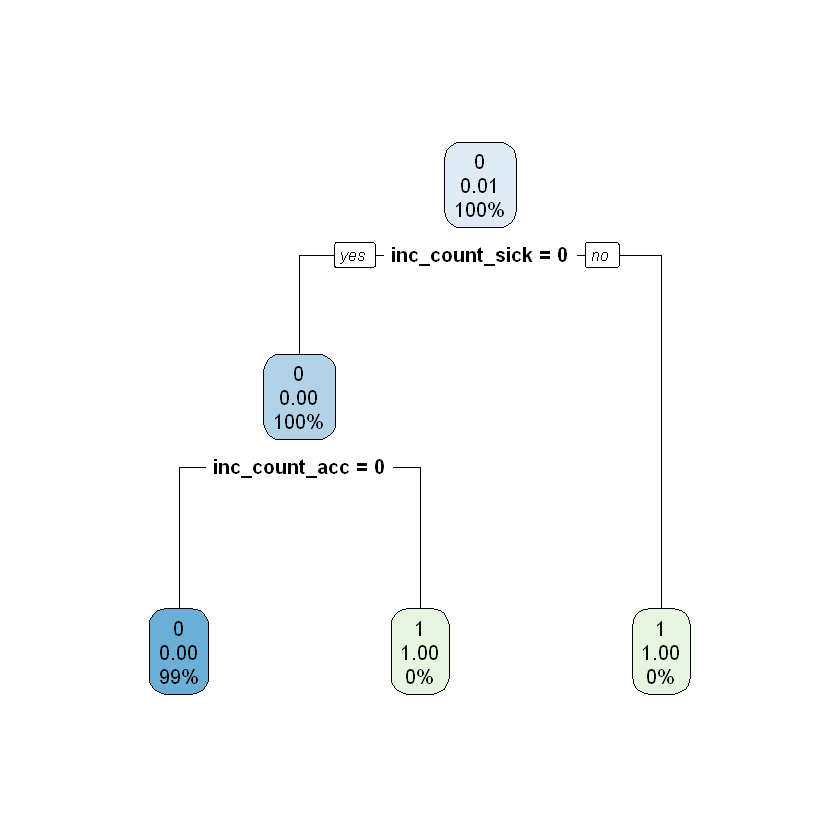

In [4]:
classi_tree <- rpart(inc_count_tot ~ inc_count_acc + inc_count_sick,
                        data = df_train,
                        method = "class")

plotcp(classi_tree, minline=TRUE)
rpart.plot(classi_tree)


As shown above, any policy having sickness or accident has a claim incident, in line with expectation.   

## Regression tree
A regression tree is basically a decision tree that is used for the task of regression which can be used to predict continuous valued outputs instead of discrete outputs.

Unlike classification tree, we cannot calculate the Gini impurity or entropy since we are predicting continuous variables. Therefore, another measure is required to tell how much our predictions deviate from the original target and that’s the entry-point of mean square error.

### Mean square error (MSE)
Mean square error is defined as
$ MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $
where $y_i$ is the actual value and $\hat{y}_i$ is the predicted value. This is the same approach used in linear regression, which aims to minimise the difference between the actual and predicted values.

Note that regression tree uses piecewise linear functions, which fits a linear function to a certain interval. if we keep dividing the dataset, the tree is able to depict any kind of non-linear trends asymptotically. This is more flexible than simple linear regression.

## Regression tree example
Let's create a scenario where termination of claims is driven by age of the claimant. Decision tree will be used to split the dataset based on age and see if result is in line with our expectation.

### Data prep

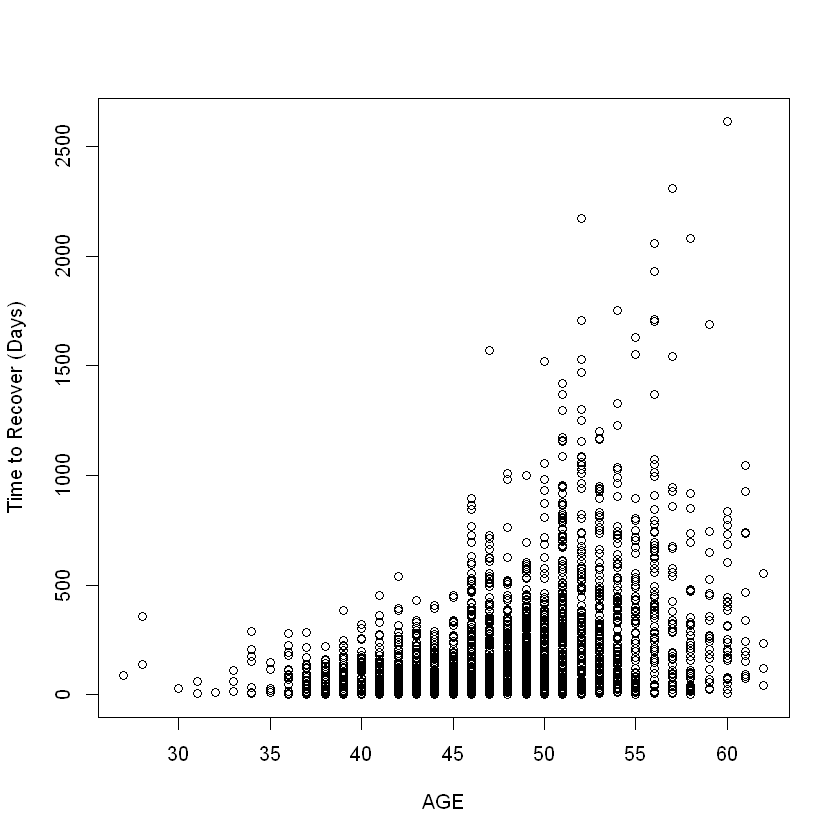

In [5]:
# select all claims
df_term <- df_train %>% filter(inc_count_tot >0) 

# add dummy claim duration data. Duration (i.e. in days) is usually considered following 
# an exponential distribution but in our recent study it follows a gamma distribution better. 
# To simplify, here we use exponential distribution CDF to back solve the x. 
# Assume lambda is 1/180 so that the average claim duration is 180 days.
df_term <- df_term %>% 
  mutate(term_day = case_when(age <= 45 ~ ceiling(log(1 - runif(nrow(df_term)))/(-1/90)),
                              age <= 50 ~ ceiling(log(1 - runif(nrow(df_term)))/(-1/180)),
                                   TRUE ~ ceiling(log(1 - runif(nrow(df_term)))/(-1/360))
                              ))

plot(df_term$age, df_term$term_day, xlab = "AGE", ylab = "Time to Recover (Days)")

### Fit regression tree

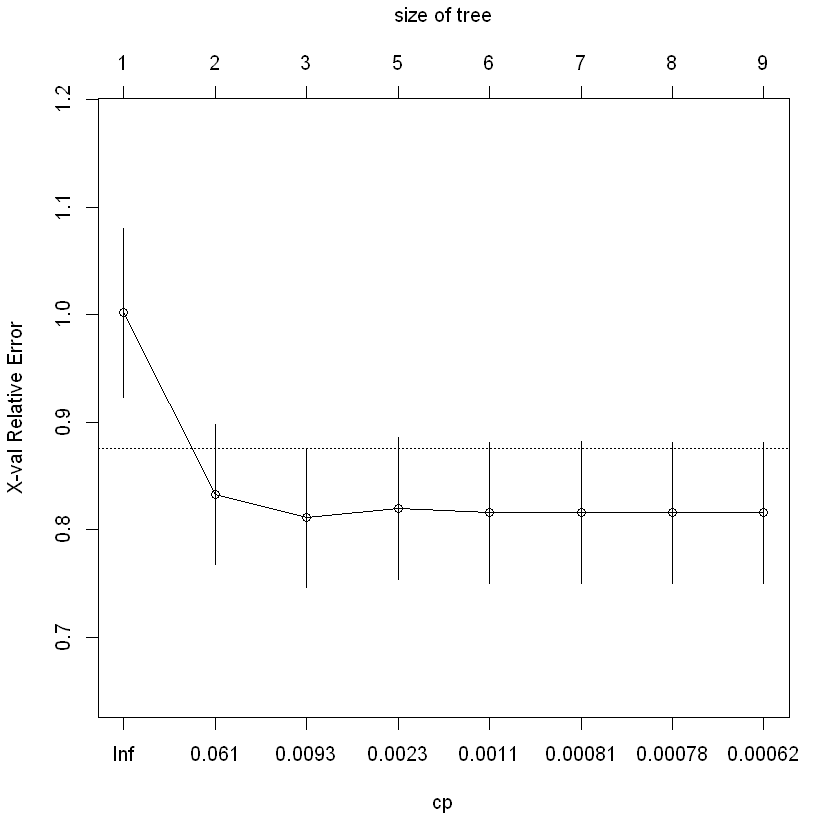


Regression tree:
rpart(formula = term_day ~ age, data = df_term, method = "anova", 
    control = rpart.control(xval = 5, minbucket = 4, cp = 5e-04))

Variables actually used in tree construction:
[1] age

Root node error: 172016888/2453 = 70125

n= 2453 

          CP nsplit rel error  xerror     xstd
1 0.17203375      0   1.00000 1.00165 0.078322
2 0.02148370      1   0.82797 0.83236 0.065199
3 0.00398784      2   0.80648 0.81096 0.064604
4 0.00136321      4   0.79851 0.81948 0.066336
5 0.00081531      5   0.79714 0.81562 0.065884
6 0.00079889      6   0.79633 0.81574 0.065899
7 0.00075895      7   0.79553 0.81557 0.065889
8 0.00050000      8   0.79477 0.81557 0.065889


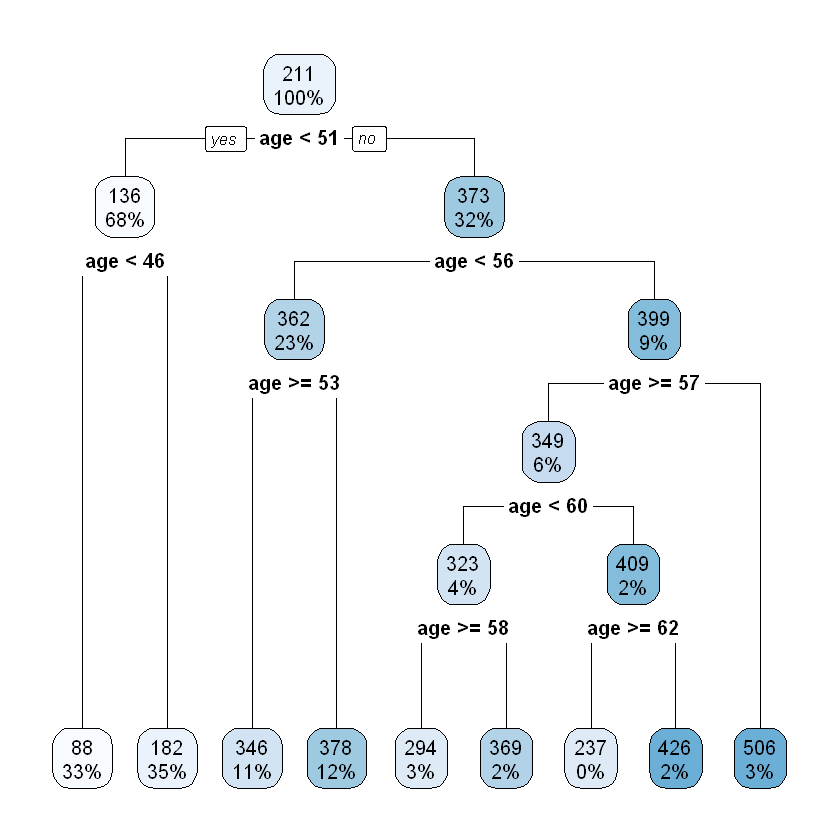

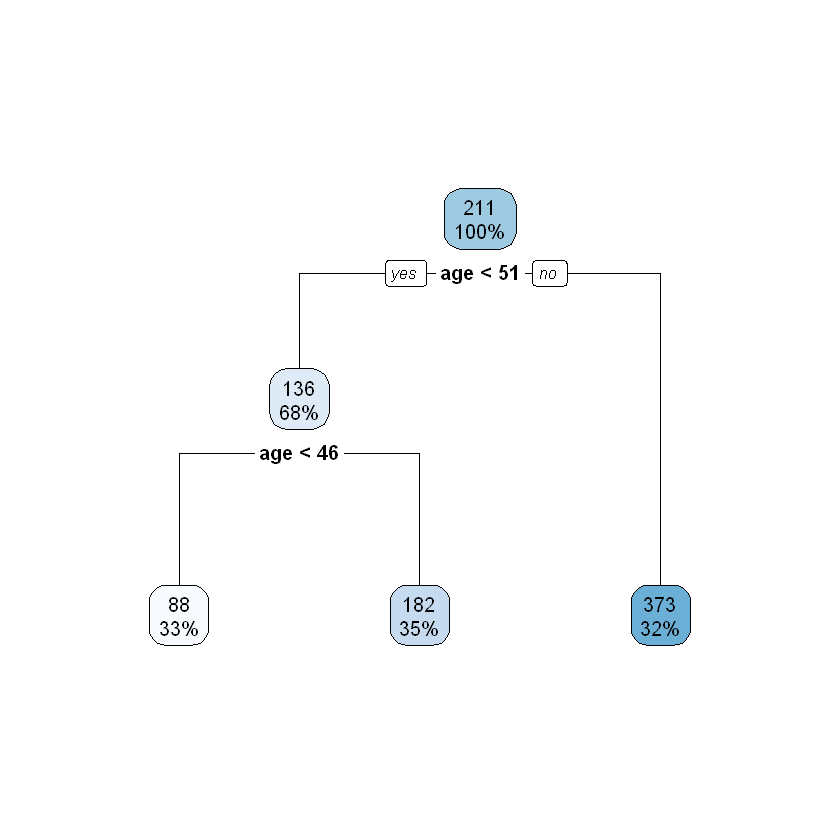

In [6]:
ageGroup_split <- rpart(term_day ~ age,
                        data = df_term,
                        method = "anova",
                        control = rpart.control(xval=5, minbucket=4, cp=0.0005))

plotcp(ageGroup_split, minline=TRUE)
rpart.plot(ageGroup_split)
printcp(ageGroup_split)

# increase cp the learning rate to prune the trees
ageGroup_pruned <- prune(ageGroup_split, cp=0.005)
rpart.plot(ageGroup_pruned)


The pruned tree splits the dataset into 3 subgroups which are exactly same as what has been defined in the data prep.

# Random forest
## Introduction of random forest
Random forest is an ensemble learning method that applies bootstrap aggregating, or Bagging, and a random selection of features, to enhance the overall performance by creating a number of trees. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned.

Bootstrap is a sampling technique. Sampling is to randomly pick data points from a known sample as such to form a new sample, either with or without replacement. Random forest uses sampling with replacement, which is to choose from a set (or original data) of size $n$, to form a new set (or sample) of size $n$.

With replacement, each data point has a chance of $\frac{1}{n}$ to be selected, and after $n$ selections, the probability that a data point is not selected, is $(1 - \frac{1}{n})^n$. When $n \to \infty$, this converges to $\frac{1}{e} \approx 0.368$. This means around 36.8% data will not be selected into the new sample, which are called "Out of Bag" (OOB) data.

The earlier random decision forests by Tin Kam Ho used the “random subspace method”, where each tree got a random subset of features. However, a few years later, Leo Breiman described the procedure of selecting different subsets of features for each node (while a tree was given the full set of features). Leo Breiman’s formulation has become the “trademark” random forest algorithm that we typically refer to these days when we speak of “random forest”. 

With the randomness in sampling of data points and features, random forest can control over-fitting well. Meanwhile, as random forest uses multiple decision trees, it also helps reduce the variance. If we treat each tree as a $iid$ random variable $X_i$ with variance $\sigma^2$, variance of their mean is
$ Var(\frac{1}{n} \sum X_i) = \frac{\sigma^2}{n}$
where $n$ denotes the number of trees.

## Train random forest model

In [7]:

new_train2 <- model.matrix(~ inc_count_tot  
                      + cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_train)

new_cv2 <- model.matrix(~ inc_count_tot  
                      + cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_cv)

new_test2 <- model.matrix(~ inc_count_tot  
                      + cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_test2)

new_train2 <- as.data.frame(new_train2) %>% rename(., Default = "(Intercept)")
new_cv2 <- as.data.frame(new_cv2) %>% rename(., Default = "(Intercept)")
new_test2 <- as.data.frame(new_test2) %>% rename(., Default = "(Intercept)")

rf.fit = randomForest(as.factor(inc_count_tot) ~., data=new_train2, 
                      ntree=100, 
                      sampsize=c(500,500),
                      importance=T)

print(rf.fit)


Call:
 randomForest(formula = as.factor(inc_count_tot) ~ ., data = new_train2,      ntree = 100, sampsize = c(500, 500), importance = T) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 38.13%
Confusion matrix:
       0      1 class.error
0 276844 170703   0.3814192
1    863   1590   0.3518141


Plotting variable importance:

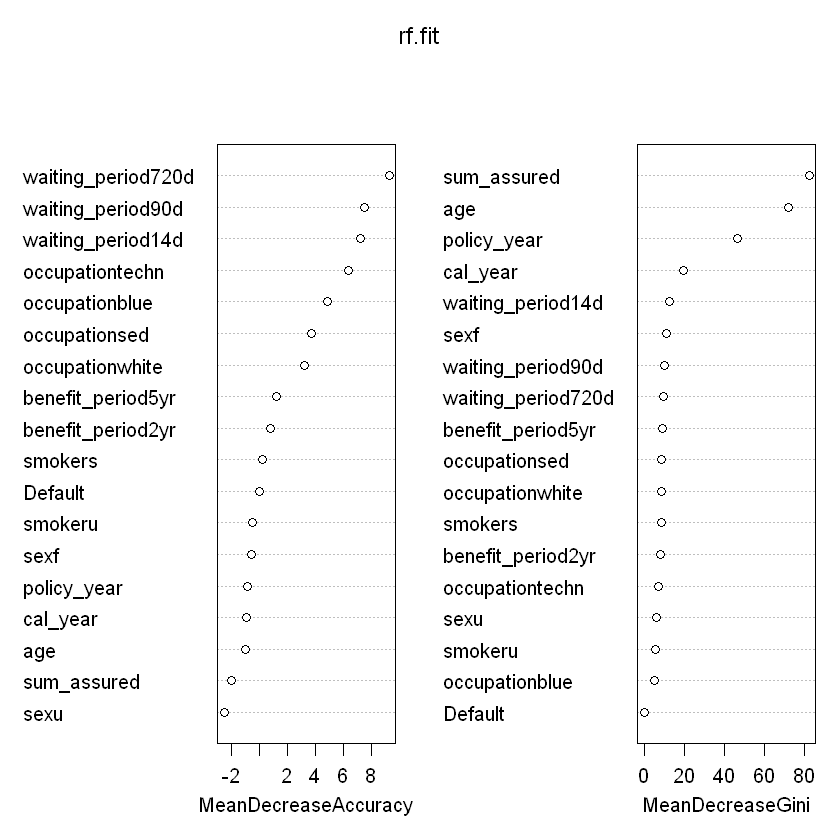

In [8]:
varImpPlot(rf.fit)

Confusion matrix and ROC:

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30786   102
         1 18945   167
                                          
               Accuracy : 0.6191          
                 95% CI : (0.6148, 0.6233)
    No Information Rate : 0.9946          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0067          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.619050        
            Specificity : 0.620818        
         Pos Pred Value : 0.996698        
         Neg Pred Value : 0.008738        
             Prevalence : 0.994620        
         Detection Rate : 0.615720        
   Detection Prevalence : 0.617760        
      Balanced Accuracy : 0.619934        
                                          
       'Positive' Class : 0               
                  

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = new_test2$inc_count_tot ~ rf.predict2[,     2], plot = TRUE, print.auc = TRUE)

Data: rf.predict2[, 2] in 49731 controls (new_test2$inc_count_tot 0) < 269 cases (new_test2$inc_count_tot 1).
Area under the curve: 0.6683

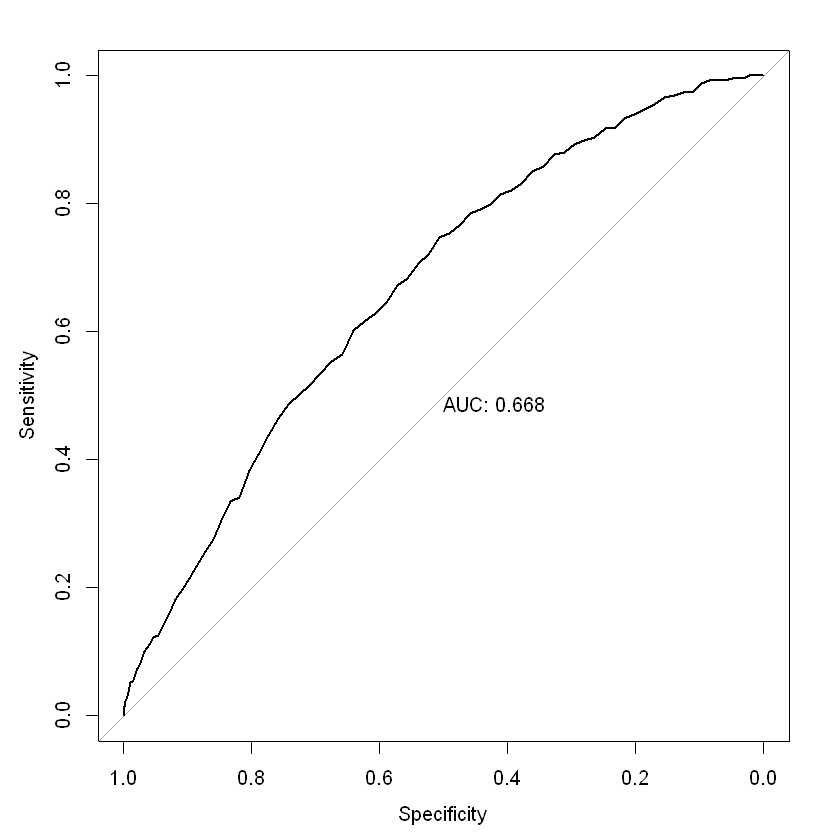

In [9]:

rf.predict = predict(rf.fit, new_test2)
confusionMatrix(as.factor(rf.predict), as.factor(new_test2$inc_count_tot))

rf.predict2 = predict(rf.fit, new_test2, type="prob")
roc(new_test2$inc_count_tot ~ rf.predict2[,2], plot = TRUE, print.auc = TRUE)


# XGBoost
## A gentle intro to gradient boosting
Before talking about XGBoost, let's take a look at gradient boosting decision trees (GBDT). Unlike Bagging technique used by random forest, Boosting sums up all the trees instead of taking majority vote. All the trees (or weak learners) are dependent. At every training iteration, the misclassified samples at the previous training step will be assigned higher weight. The predicted outcome is the weighted sum of all the learners.

As an example, to predict the age of a person (say actual value is 40):
* the GBDT model trains the first weak learner (or tree) to make a prediction of 30. Apparently the variance of this prediction against actual value is 10. 
* Then in the next tree, it makes another prediction of age 6 (out of 10), which reduces the variance to 4. 
* Then in the third tree, the predicted age is 3 (out of 4), with variance down to 1. 
* The last tree predicts the age of 1 (out of 1). 
* Finally, if we add up all the 4 trees, we will end up having a predicted value of age 40.

![Intuition behind gradient boosting (source: https://explained.ai/gradient-boosting/index.html)](../_static/trees/golf-gbdt.png)

Just like playing golf, GBDT model tries to explain the residual of the previous fitting. Actually, the algorithm uses negative gradient to approximate the residual. For each sample point, the loss function is in the form of
$ l(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2$
Note that this is just same as mean square error, the $\frac{1}{2}$ at the front is just to offset the coefficient 2 that will emerge when calculating derivative, without changing the overall trend. Thus, the negative gradient is
$ -\frac{\partial l}{\partial \hat{y}_i} = (y_i - \hat{y}_i)$
which is exactly the variance between the actual and predicted value.

## Pros and cons of GBDT
Pros:

* Fast predicting process, allowing multi-thread computation.
* Works well on dense data.
* Good interpretability and robustness, can automatically find higher order relationships between the features.

Cons:

* SVM and neural network may perform better than GBDT on sparse data.
* Training takes longer as trees are inter-dependent.

## GBDT vs Random Forest
Similarity:

* Both contains multiple trees, and all trees are involved in determining final result.
* Both can handle classification or regression problems.

Difference:

* Trees in random forest can be derived in parallel, however for GBDT they need to come one after another.
* Random forest uses majority vote, while GBDT takes weighted sum of all trees.
* Random forest is not sensitive to outliers, but GBDT is.
* Random forest reduces the model variance, and GBDT reduces the model bias.

## Introduction of XGBoost
XGBoost stands for eXtreme Gradient Boosting and is developed on the framework of gradient boosting by Tianqi Chen et. al. It inherits the nature of GBDT model and has made several enhancements to be more powerful and efficient.

One of the main features about XGBoost is that it has enabled parallel computing. Unlike random forest where each tree is mutually independent, XGBoost as a variant of GBDT still needs to generate trees in sequence. The way it realises parallel learning is by introducing a block structure. As stated in the paper, the most timing consuming part of tree learning is to get the data into sorted order. The algorithm stores data in in-memory units called "block", with each column sorted by the corresponding feature value. By doing so, the input data only needs to be computed once before training, and the blocks can be re-used in later iterations.

While machine learning algorithms have support for tuning and can work with external programs, XGBoost has built-in parameters for regularisation and cross-validation to make sure both bias and variance is kept at a minimal.

## XGBoost vs Original GBDT
* XGBoost uses L2 norm which controls over-fitting and allows model to converge faster than L1 norm. For more information about regularisation, this article is a good reading https://www.kaggle.com/residentmario/l1-norms-versus-l2-norms

* The original GBDT only uses the first order derivative of the loss function, while XGBoost uses both the first and second order derivatives (by Taylor series). Second order derivative allows gradient to descend faster in the right direction.

* The original GBDT uses tree base learner, while XGBoost also supports other types such as linear learner. Though in most cases, we may not use linear learner as a base learner, because adding multiple linear models together still yields a linear model.

* The original GBDT uses all data points in every iteration. XGBoost randomly samples the data to prevent over-fitting.

* XGBoost can handle missing values. Common treatments are to: 1) use median values, or 2) do so but also consider the similarity of the data point against all others (proximity measures). The strategy in XGBoost is to put all samples where the value of the split feature is unknown in one of the two children (left or right sub-tree), whichever side gives optimised training loss. Clever isn't it? This assumes that the training data and predicting data have same distribution.

## Train XGBoost model

[1]	train-logloss:0.680530	val-logloss:0.680454 
Multiple eval metrics are present. Will use val_logloss for early stopping.
Will train until val_logloss hasn't improved in 50 rounds.

[11]	train-logloss:0.626824	val-logloss:0.627098 
[21]	train-logloss:0.608418	val-logloss:0.609160 
[31]	train-logloss:0.596263	val-logloss:0.597342 
[41]	train-logloss:0.585442	val-logloss:0.586823 
[51]	train-logloss:0.577694	val-logloss:0.579185 
[61]	train-logloss:0.571021	val-logloss:0.572678 
[71]	train-logloss:0.565651	val-logloss:0.567431 
[81]	train-logloss:0.558594	val-logloss:0.560511 
[91]	train-logloss:0.553997	val-logloss:0.556084 
[100]	train-logloss:0.550225	val-logloss:0.552311 


                Length Class              Mode       
handle               1 xgb.Booster.handle externalptr
raw             556926 -none-             raw        
best_iteration       1 -none-             numeric    
best_ntreelimit      1 -none-             numeric    
best_score           1 -none-             numeric    
best_msg             1 -none-             character  
niter                1 -none-             numeric    
evaluation_log       3 data.table         list       
call                 9 -none-             call       
params              11 -none-             list       
callbacks            3 -none-             list       
feature_names       18 -none-             character  
nfeatures            1 -none-             numeric    

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 33350   112
         1 16381   157
                                         
               Accuracy : 0.6701         
                 95% CI : (0.666, 0.6743)
    No Information Rate : 0.9946         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0082         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.670608       
            Specificity : 0.583643       
         Pos Pred Value : 0.996653       
         Neg Pred Value : 0.009493       
             Prevalence : 0.994620       
         Detection Rate : 0.667000       
   Detection Prevalence : 0.669240       
      Balanced Accuracy : 0.627125       
                                         
       'Positive' Class : 0              
                                      

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = test_label ~ xgb_pred1, plot = TRUE, print.auc = TRUE)

Data: xgb_pred1 in 49731 controls (test_label 0) < 269 cases (test_label 1).
Area under the curve: 0.6811

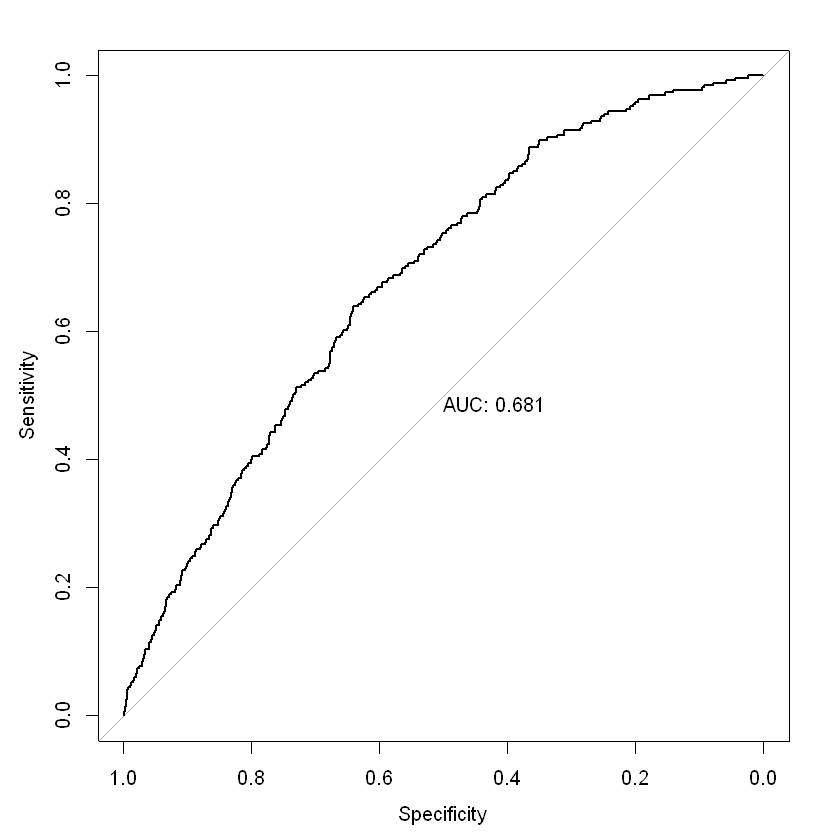

In [10]:


new_train <- model.matrix(inc_count_tot  ~ 
                        cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_train)

new_cv <- model.matrix(inc_count_tot  ~ 
                        cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_cv)

new_test <- model.matrix(inc_count_tot  ~ 
                        cal_year
                      + policy_year
                      + sex                           
                      + smoker
                      + benefit_period
                      + waiting_period
                      + occupation
                      + age          
                      + sum_assured             
                       , data = df_test2)


# prepare xgb matrix 
DM_train <- xgb.DMatrix(data = new_train, label = train_label) 
DM_cv <- xgb.DMatrix(data = new_cv, label = cv_label)
DM_test <- xgb.DMatrix(data = new_test, label = test_label)

# Given the dataset is highly imbalanced, we use 'scale_pos_weight' 
# to re-balance it which is the number of negative observations (i.e. "0") 
# over the number of positive observations (i.e. "1").
n_pos <- df_train %>% filter(inc_count_tot==1) %>% nrow(.)
n_neg <- df_train %>% filter(inc_count_tot==0) %>% nrow(.)

params <- list(booster = "gbtree"
               , objective = "binary:logistic"
               , eta=0.1
               , gamma=0
               , max_depth=6
               , min_child_weight=1
               , subsample=1
               , colsample_bytree=1
               , scale_pos_weight=n_neg/n_pos)

# xgb training with watchlist to show cross-validation
xgb1 <- xgb.train(params = params, data = DM_train, nrounds = 100, watchlist = list(train=DM_train, val=DM_cv)
                   ,print_every_n = 10
                   ,early_stopping_rounds = 50
                   ,maximize = F, eval_metric = "logloss")

summary(xgb1)
xgb_pred1 <- predict (xgb1, DM_test)

confusionMatrix(as.factor(as.numeric(xgb_pred1 >0.5)), as.factor(test_label))

roc(test_label ~ xgb_pred1, plot = TRUE, print.auc = TRUE)
